In [73]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import sqlite3
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA
import warnings
from pathlib import Path

from utils.data_processing import create_feables

warnings.simplefilter("ignore")

start = time()
## Fetching data
database_path = Path(os.path.abspath('')).parent / "../datasets/database.sqlite"
conn = sqlite3.connect(database_path)

#Defining the number of jobs to be run in parallel during grid search
n_jobs = 1 #Insert number of parallel jobs here

match_data_rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id",
                   "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
                   "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7",
                   "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
                   "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
                   "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]

# Construct SQL to select only rows with data
match_data_sql = 'SELECT * FROM MATCH' + ' WHERE ' + " IS NOT NULL AND ".join(match_data_rows) + ';'

match_data = pd.read_sql(match_data_sql, conn)
match_data = match_data.tail(10000)

#Creating features and labels based on data provided
bk_cols = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
bk_cols_selected = ['B365', 'BW']
feables = create_feables(match_data, None, bk_cols_selected, get_overall = True)
inputs = feables.drop('match_api_id', axis = 1)

#Exploring the data and creating visualizations
labels = inputs.loc[:,'label']
features = inputs.drop('label', axis = 1)



Generating match features...
Match features generated in 5.5 minutes
Generating match labels...
Match labels generated in 0.5 minutes
Generating bookkeeper data...
Bookkeeper data generated in 0.0 minutes


In [83]:
from sklearn.model_selection import train_test_split


#Splitting the data into Train
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.1, random_state = 0, stratify = labels)

X_train.head()


,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won,games_against_lost,League_10257.0,League_13274.0,League_15722.0,League_17642.0,League_19694.0,League_21518.0,League_24558.0,B365_Win,B365_Draw,B365_Defeat,BW_Win,BW_Draw,BW_Defeat
7383,17.0,2.0,6.0,6.0,2.0,1.0,0,0,0,0,0,1,0,0.869914,0.093951,0.036135,0.849457,0.103823,0.046720
2428,-5.0,6.0,3.0,4.0,1.0,0.0,0,1,0,0,0,0,0,0.581395,0.209302,0.209302,0.550964,0.242424,0.206612
6042,4.0,-14.0,6.0,1.0,3.0,0.0,0,0,0,0,1,0,0,0.691412,0.197962,0.110626,0.698685,0.191219,0.110096
5083,-5.0,-5.0,1.0,2.0,1.0,0.0,0,0,0,0,1,0,0,0.390164,0.275410,0.334426,0.375723,0.277457,0.346821
4708,4.0,3.0,2.0,2.0,0.0,0.0,0,0,0,0,1,0,0,0.751067,0.170697,0.078236,0.720000,0.180000,0.100000


In [84]:
# Match outcome
y_train.head()

# Number of possible outcomes
# 1 = win
# 0 = draw
# -1 = lose
print('Number of possible outcomes', np.unique(y_train.values).shape[0])


Number of possible outcomes 3


In [85]:
# Get number of columns by tacking the number of columns in the X_train
columns = X_train.shape[1]
print('Number of columns:', columns)

Number of columns: 19


In [86]:
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import Input, Activation, Flatten, Dense, Concatenate, Dropout
from keras.optimizers import Adam
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

def build_keras_model():
    model = Sequential()
    model.add(Dense(32, input_dim=columns, activation='relu', kernel_regularizer=regularizers.l2(0.0002)))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0002)))
    model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.0002)))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.0002)))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001), metrics=['accuracy']) # categorical_crossentropy
    return model

model = build_keras_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 32)                640       
_________________________________________________________________
dense_35 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_36 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_37 (Dense)             (None, 3)                 27        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [78]:
from keras.utils.np_utils import to_categorical

print(y_train)
# print(to_categorical(y_train))

1964    1.0
4254   -1.0
3422   -1.0
8788    1.0
3758    1.0
6067   -1.0
7518    1.0
3905    1.0
2460    1.0
4933   -1.0
5246    1.0
4973    1.0
5888    1.0
7739   -1.0
6099    1.0
4816    1.0
1632    1.0
7086    1.0
5380    0.0
7920    1.0
6534    1.0
5053    1.0
5853   -1.0
846     1.0
5761    0.0
5190    0.0
648     0.0
910     1.0
1628    0.0
6740    1.0
       ... 
5422    1.0
6457   -1.0
7301    0.0
8574   -1.0
8775    1.0
1331    1.0
3329   -1.0
4261    0.0
2709    0.0
3661    1.0
219     1.0
3927    1.0
2287    1.0
1013    0.0
4214    1.0
1791   -1.0
5838    1.0
369     1.0
2012    1.0
7186    1.0
842     0.0
5681   -1.0
4597    1.0
7037    1.0
4466   -1.0
2047    1.0
4934   -1.0
7338    1.0
4415    0.0
2609    0.0
Name: label, Length: 5257, dtype: float64


In [88]:
categorical = to_categorical(y_train + 1, num_classes=3)
history = model.fit(X_train, categorical, batch_size=32, epochs=100, validation_split=0.1)

Train on 6759 samples, validate on 751 samples
Epoch 1/100
6759/6759 [==============================] - 2s 306us/step - loss: 0.2349 - acc: 0.4061 - val_loss: 0.2213 - val_acc: 0.4261
Epoch 2/100
6759/6759 [==============================] - 0s 71us/step - loss: 0.2148 - acc: 0.4697 - val_loss: 0.2115 - val_acc: 0.4767
Epoch 3/100
6759/6759 [==============================] - 0s 71us/step - loss: 0.2108 - acc: 0.4909 - val_loss: 0.2097 - val_acc: 0.4860
Epoch 4/100
6759/6759 [==============================] - 0s 71us/step - loss: 0.2095 - acc: 0.4984 - val_loss: 0.2085 - val_acc: 0.4927
Epoch 5/100
6759/6759 [==============================] - 0s 73us/step - loss: 0.2085 - acc: 0.5042 - val_loss: 0.2076 - val_acc: 0.4913
Epoch 6/100
6759/6759 [==============================] - 1s 78us/step - loss: 0.2077 - acc: 0.5047 - val_loss: 0.2066 - val_acc: 0.4860
Epoch 7/100
6759/6759 [==============================] - 1s 94us/step - loss: 0.2070 - acc: 0.5106 - val_loss: 0.2057 - val_acc: 0.4927


6759/6759 [==============================] - 1s 82us/step - loss: 0.1967 - acc: 0.5366 - val_loss: 0.1985 - val_acc: 0.5246
Epoch 61/100
6759/6759 [==============================] - 1s 98us/step - loss: 0.1966 - acc: 0.5388 - val_loss: 0.1985 - val_acc: 0.5233
Epoch 62/100
6759/6759 [==============================] - 1s 111us/step - loss: 0.1965 - acc: 0.5381 - val_loss: 0.1983 - val_acc: 0.5286
Epoch 63/100
6759/6759 [==============================] - 1s 76us/step - loss: 0.1964 - acc: 0.5384 - val_loss: 0.1981 - val_acc: 0.5300
Epoch 64/100
6759/6759 [==============================] - 1s 89us/step - loss: 0.1963 - acc: 0.5382 - val_loss: 0.1982 - val_acc: 0.5286
Epoch 65/100
6759/6759 [==============================] - 1s 91us/step - loss: 0.1962 - acc: 0.5381 - val_loss: 0.1981 - val_acc: 0.5286
Epoch 66/100
6759/6759 [==============================] - 1s 132us/step - loss: 0.1961 - acc: 0.5408 - val_loss: 0.1980 - val_acc: 0.5260
Epoch 67/100
6759/6759 [============================

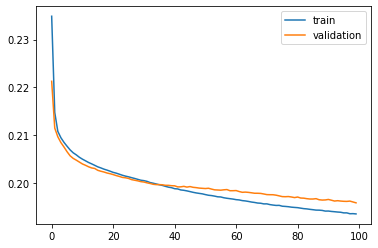

In [89]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

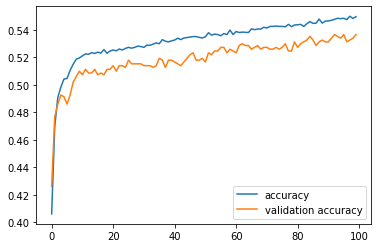

In [90]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

In [91]:
predictions = np.argmax(model.predict(X_test), axis=1)-1
accuracy = (predictions == y_test).mean()
print("Test set accuracy:", accuracy)

Test set accuracy: 0.5293413173652695
